In [1]:
import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

In [2]:
data = CleanedData(loc='./data/joined.csv', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

D:\Users\gerla\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [3]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [4]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
548100,21.000000,6.025173,-74.652093,13.538964,10.087433,13.349794,11.577533,7.359814,3.169708,152.0,0.0,102.0,1.0
329562,69.500000,51.433200,7.661600,11.077393,7.519692,10.977192,8.371936,5.888185,2.850430,121.0,0.0,317.0,1.0
255941,38.781474,23.541513,78.289633,11.517495,7.550135,11.250937,9.980680,4.768044,1.892333,143.0,0.0,248.0,2.0
28669,69.500000,50.652100,9.162400,9.770870,6.297109,9.658162,7.188413,5.633177,3.100023,94.0,0.0,179.0,1.0
189610,69.500000,52.636700,9.845100,9.840281,6.505784,9.710024,7.392648,5.460451,3.563249,120.0,0.0,310.0,1.0


In [5]:
# Loading up the neural netowrk models

model_1 = nn.network_1()
model_2 = nn.network_1()
model_3 = nn.network_2()
model_4 = nn.network_2()

nn.load_model(model_1, './model_1.pth')
nn.load_model(model_2, './model_2.pth')
nn.load_model(model_3, './model_3.pth')
nn.load_model(model_4, './model_4.pth')

In [6]:
print(f'training accuracy of model_1: {nn.eval(model_1, X_train, y_train):.2f}%')
print(f'validation accuracy of model_1: {nn.eval(model_1, X_test, y_test):.2f}%')
print(f'training accuracy of model_2: {nn.eval(model_2, X_train, y_train):.2f}%')
print(f'validation accuracy of model_2: {nn.eval(model_2, X_test, y_test):.2f}%')
print(f'training accuracy of model_3: {nn.eval(model_3, X_train, y_train):.2f}%')
print(f'validation accuracy of model_3: {nn.eval(model_3, X_test, y_test):.2f}%')
print(f'training accuracy of model_4: {nn.eval(model_4, X_train, y_train):.2f}%')
print(f'validation accuracy of model_4: {nn.eval(model_4, X_test, y_test):.2f}%')

training accuracy of model_1: 95.17%
validation accuracy of model_1: 95.17%
training accuracy of model_2: 95.66%
validation accuracy of model_2: 95.71%
training accuracy of model_3: 94.18%
validation accuracy of model_3: 94.14%
training accuracy of model_4: 98.02%
validation accuracy of model_4: 97.94%


In [7]:
model_1_y_ = torch.argmax(torch.softmax(model_1(torch.tensor(X_train.values).float()), dim=1), dim=1)
model_2_y_ = torch.argmax(torch.softmax(model_2(torch.tensor(X_train.values).float()), dim=1), dim=1)
model_3_y_ = torch.argmax(torch.softmax(model_3(torch.tensor(X_train.values).float()), dim=1), dim=1)
model_4_y_ = torch.argmax(torch.softmax(model_4(torch.tensor(X_train.values).float()), dim=1), dim=1)

In [8]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

In [9]:
conf_matrix_1 = sklearn.metrics.confusion_matrix(y_train.values, model_1_y_)
conf_matrix_2 = sklearn.metrics.confusion_matrix(y_train.values, model_2_y_)
conf_matrix_3 = sklearn.metrics.confusion_matrix(y_train.values, model_3_y_)
conf_matrix_4 = sklearn.metrics.confusion_matrix(y_train.values, model_4_y_)

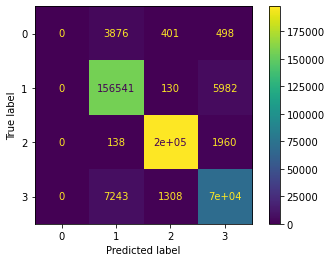

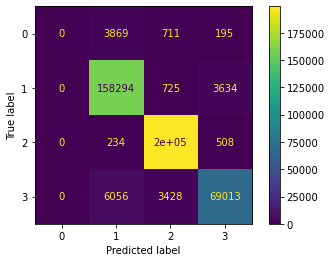

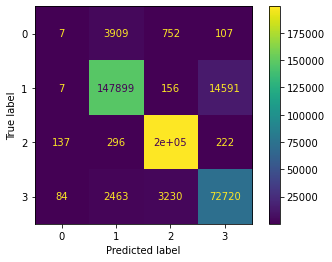

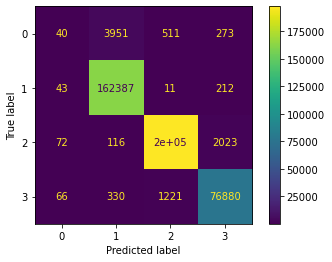

In [17]:
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_1).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_2).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_3).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_4).plot()

## Adaboost

In [11]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
adaboost.fit(X_train,y_train) 

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=1, n_estimators=25)

### Training Set Accuracy Score

In [12]:
adaboost.score(X_train,y_train)

0.9968870478313623

### Test set Accuracy Score

In [13]:
adaboost.score(X_test,y_test)

0.9913160491612093

### Save Model to pkl file

In [14]:
# Save Model to file
file_name = "./data/adaboost_model.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(adaboost, file)

### Confusion Matrices

#### Test Data Set

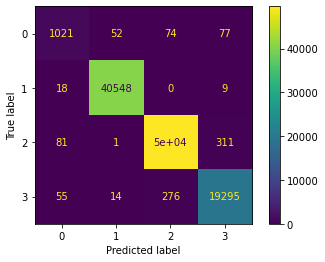

In [15]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

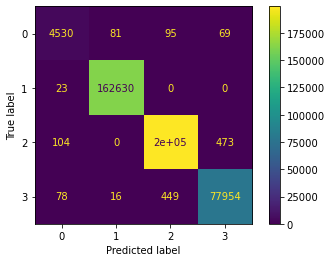

In [16]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()